In [63]:
import numpy as np
import pandas as pd

from pathlib import Path
import matplotlib.pyplot as plt
import IPython
from IPython.display import display
from PIL import Image
%matplotlib inline
import os
import time
import cv2
import glob
import random

from keras.preprocessing import image

seed = 10
random.seed(seed)
np.random.seed(seed)

# Load Training Image

In [92]:
train_fire_img = glob.glob('../input/apimembara/Training/Training/Fire/*.jpg')
train_nofire_img = glob.glob('../input/apimembara/Training/Training/No_Fire/*.jpg')

print("Total number of training fire images: ", len(train_fire_img))
print("Total number of training no fire images: ", len(train_nofire_img))

# make train_image_names as serie object
train_fire_img = pd.Series(train_fire_img)
train_nofire_img = pd.Series(train_nofire_img)

train_img = train_fire_img.append(train_nofire_img)
train_img = train_img.sample(frac=1).reset_index(drop=True) # shuffling

print("Total number of training images: ", len(train_img))

Total number of training fire images:  25018
Total number of training no fire images:  14357
Total number of training images:  39375


In [28]:
test_fire_img = glob.glob('../input/apimembara/Test/Test/Fire/*.jpg')
test_nofire_img = glob.glob('../input/apimembara/Test/Test/No_Fire/*.jpg')

print("Total number of test fire images: ", len(test_fire_img))
print("Total number of test no fire images: ", len(test_nofire_img))

# make train_image_names as serie object
test_fire_img = pd.Series(test_fire_img)
test_nofire_img = pd.Series(test_nofire_img)

test_img = test_fire_img.append(test_nofire_img)
test_img = test_img.sample(frac=1).reset_index(drop=True) # shuffling

print("Total number of test images: ", len(test_img))

Total number of test fire images:  5137
Total number of test no fire images:  3480
Total number of test images:  8617


In [29]:
masked_img = glob.glob('../input/apimembara/Masks/Masks/*.png')
print("Total number of masked images: ", len(masked_img))

masked_img = pd.Series(masked_img)

Total number of masked images:  2003


In [31]:
# train_df: a dataframe with 2 field: filename, label

train_df = pd.DataFrame()

# generate Filename field
train_df['filename'] = train_img.map(lambda img_name: img_name.split("/")[-1])

# generate ClassId field
train_df['label'] = train_img.map(lambda img_name: int(1) if img_name.split("/")[-2] == 'Fire' else int(0))

train_df.tail()

,filename,label
14352,lake_resized_lake_frame10913.jpg,0
14353,resized_frame18291.jpg,0
14354,lake_resized_lake_frame4700.jpg,0
14355,lake_resized_lake_frame1470.jpg,0
14356,lake_resized_lake_frame9436.jpg,0


In [32]:
# test_df: a dataframe with 2 field: filename, label

test_df = pd.DataFrame()

# generate Filename field
test_df['filename'] = test_img.map(lambda img_name: img_name.split("/")[-1])

# generate ClassId field
test_df['label'] = test_img.map(lambda img_name: int(1) if img_name.split("/")[-2] == 'Fire' else int(0))

test_df.tail()

,filename,label
3475,resized_test_nofire_frame2793.jpg,0
3476,resized_test_nofire_frame534.jpg,0
3477,resized_test_nofire_frame433.jpg,0
3478,resized_test_nofire_frame1729.jpg,0
3479,resized_test_nofire_frame3330.jpg,0


# Visualize Images

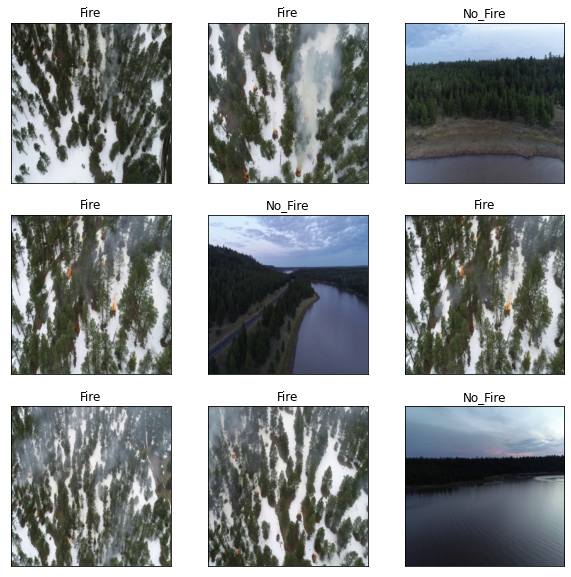

In [65]:
plot_df = train_df.sample(9).reset_index()
plt.figure(figsize=(10, 10))

for i in range(9):
    img_name = plot_df.loc[i, 'filename']
    label_str = 'Fire' if (plot_df.loc[i, 'label'] == 1) else 'No_Fire'
    plt.subplot(3,3,i+1)
    plt.imshow(plt.imread(os.path.join('../input/apimembara/Training/Training/',label_str, img_name)))
    plt.title(label_str)
    plt.xticks([])
    plt.yticks([])

# Class Distribution

In [42]:
class_id_distribution = train_df['label'].value_counts()
print(class_id_distribution)

1    25018
0    14357
Name: label, dtype: int64


<BarContainer object of 2 artists>

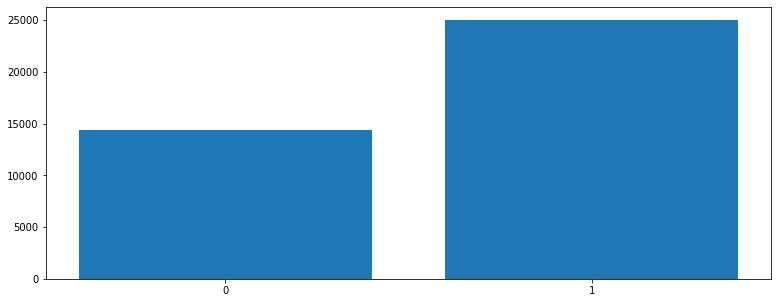

In [43]:
plt.figure(figsize=(13,5))
plt.xticks(np.arange(43))
plt.bar(class_id_distribution.index, class_id_distribution.values)

# Data Preprocessing

Image Preprocessing with OpenCV
- Masking
- Segmentation
- Image Sharpening

In [66]:
# https://www.kaggle.com/code/delllectron/fire-detection-computer-vision

#masking function
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250,255,255])
    
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

#image segmentation function
def segment_image(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

#sharpen the image
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

# function to get an image
def read_img(img_name, label, size):
    label_str = 'Fire' if (label == 1) else 'No_Fire'
    
    img = image.load_img(os.path.join('../input/apimembara/Training/Training/',label_str, img_name), target_size=size)
    #convert image to array
    img = image.img_to_array(img)
    return img

## Visualize Processed Images

   index                         filename  label
0  24438            resized_frame2699.jpg      1
1  13470  lake_resized_lake_frame2612.jpg      0
2  11602   lake_resized_lake_frame262.jpg      0
3   1948           resized_frame25772.jpg      1


<Figure size 720x720 with 0 Axes>

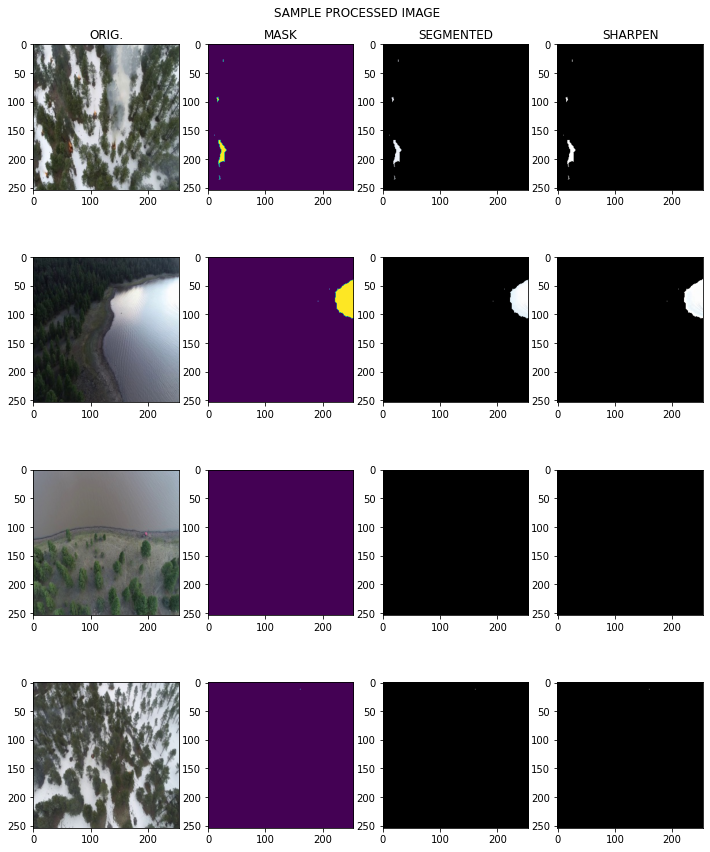

In [99]:
plot_df = train_df.sample(4).reset_index()
plt.figure(figsize=(10, 10))

print(plot_df)

fig, ax = plt.subplots(4, 4, figsize=(12, 15));
plt.suptitle('SAMPLE PROCESSED IMAGE', x=0.5, y=0.9)

ax[0,0].set_title('ORIG.', fontsize=12)
ax[0,1].set_title('MASK', fontsize=12)
ax[0,2].set_title('SEGMENTED', fontsize=12)
ax[0,3].set_title('SHARPEN', fontsize=12)

for i in range(4):    
    #get an image
    img = read_img(plot_df['filename'][i],plot_df['label'][i], (254,254))
    #mask
    image_mask = create_mask_for_plant(img)
    #segmentation
    image_segmented = segment_image(img)
    #sharpen the image
    image_sharpen = sharpen_image(image_segmented)

    # plt.tight_layout(1)

    ax[i,0].imshow(img/255);
    ax[i,1].imshow(image_mask);
    ax[i,2].imshow(image_segmented);
    ax[i,3].imshow(image_sharpen);

In [89]:
def shaper(row):
    img_name = row['filename']
    label_str = 'Fire' if (row['label'] == 1) else 'No_Fire'
    
    shape = image.load_img(os.path.join('../input/apimembara/Training/Training/',label_str, img_name)).size
    row['height'] = shape[1]
    row['width'] = shape[0]
    return row

plot_df = train_df.sample(5).reset_index()

plot_df = plot_df.apply(shaper,axis=1)
plot_df.head(5)

,index,filename,label,height,width
0,4579,resized_frame17818.jpg,1,254,254
1,7239,lake_resized_lake_frame3831.jpg,0,254,254
2,19688,resized_frame23773.jpg,1,254,254
3,5788,resized_frame1718.jpg,1,254,254
4,12815,resized_frame23925.jpg,1,254,254
